In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from collections.abc import Iterable

In [2]:
# Nghost = 2 # Number of ghost zones

# Define a class to hold the parameters of the hydrodynamics simulation
# and run the sim and handled the results
class Burgers(object):
    def __init__(self, Ncells, IC, outCad=0, Nghost=2, tf=1.0, interpolation="minmod"): 
        # Output cadence -- how often to produce a plot
        self._outCad = outCad
        # the current time
        self._t = 0.0
        # final time, the length of the evolution
        self.tf = 1.0
        # number of ghost zones
        self.Nghost=Nghost
        # interpolation method
        self.interpolation = interpolation
        self._N = Ncells+2*self.Nghost
        self._dx = 1.0/Ncells 
        self._x = np.linspace((0.5-self.Nghost)*self._dx,1+(self.Nghost-0.5)*self._dx, Ncells+2*self.Nghost)
        self._u = self._setIC(IC, self._x) 
        self._dt = 0.25*self._dx

        # store the data
        self._tList = []
        self._tList.append(self._t)
        self._uxList = []
        self._uxList.append(self._u)

    def _setIC(self,IC, x):
        if (IC=="sine"):
            self._IC = lambda x : (0.35+0.25*np.sin(4.0*np.pi*x))
            return 0.35+0.25*np.sin(4.0*np.pi*x)
        elif (IC=="step"):
            self._IC = lambda x : (0.5 if (abs(x-0.5)<0.25) else 1)
            f = np.ones_like(x)
            f[abs(x-0.5)<0.25] = 0.5
            return f
        else:
            raise ValueError("IC undefined") 


    """
    The exact solution is given by the method of characteristics
    """
    def exact_soln(self, t, x):
        def u0(x):
            # this function should be consistent with the initial condition
            return self._IC(x)

        def xx(t, x0):
            return (x0 + u0(x0) * t)

        def find_x0(t, x):
            func = lambda x0 : (x0 + u0(x0) * t - x)
            return fsolve(func, x)[0]

        def u(t, x0):
            return u0(x0)

        def u_real(t, x):
            if isinstance(x, Iterable):
                return [u(t, find_x0(t,x1)) for x1 in x]
            else:
                return u(t, find_x0(t, x))

        return u_real(t, x)

    def get_exact_at(self, t):
        return self.exact_soln(t, self._x)

    def _physFlux(self, u):
        return 0.5*u**2

    def _flux(self, ul, ur): #ul/ur is left/right of interface
        # Roe's method
        uavg = 0.5 * (ul + ur)
        delta = ur - ul
        return (
                0.5*(self._physFlux(ul)+self._physFlux(ur))
                -0.5*abs(uavg)*delta
               )

    def _uPlusMinus(self, u):
        if self.interpolation == "minmod":
            slope = np.zeros_like(u)
            deltau = u[1:] - u[:-1]
            slope[1:-1] = deltau[1:]
            I = abs(deltau[1:]) > abs(deltau[:-1])
            slope[1:-1][I] = deltau[:-1][I]
            slope[1:-1][deltau[1:]*deltau[:-1]<=0] = 0
            return (u+0.5*slope,u-0.5*slope)
        elif self.interpolation == "linear":
            up = 1.0*u
            up[:-1] = 0.5*(u[1:]+u[:-1])
            um = 1.0*u
            um[1:] = 0.5*(u[1:]+u[:-1])
            return (up,um)
        else:
            raise ValueError("Interpolation method undefined") 

    def _udot(self, u):
        #Calculate left and right hand states at interfaces
        up,um = self._uPlusMinus(u)
        F = np.zeros(len(u)+1)
        #Calculate flux at interfaces
        F[1:-1] = self._flux(up[:-1],um[1:])
        return (1.0/self._dx)*(F[:-1]-F[1:])

    def _applyBC(self, u):
        #Copy over ghost cells assuming periodic BCs
        ubc = 1.0*u
        ubc[0:self.Nghost] = u[-(2*self.Nghost):-self.Nghost]
        ubc[-self.Nghost:] = u[self.Nghost:2*self.Nghost]
        return ubc

    """
    The real evolving step function.
    """
    def _step(self):
        #Use Runge-Kutta 2
        uhalf = self._u + 0.5*self._dt*self._udot(self._u)
        uhalf = self._applyBC(uhalf)
        self._u += self._dt*self._udot(uhalf)
        self._u = self._applyBC(self._u)
        self._t += self._dt
        self._tList.append(self._t)
        self._uxList.append(self._u)

    def evolve(self, save=True, show=False):
        while(self._t<self.tf):
            if (self._outCad>0): self._output(save=save, show=show)
            self._step()
        if (self._outCad>0): self._output(save=save, show=show)

    def _output(self, save=True, show=False):
        nstep = np.rint(self._t/self._dt)
        if (nstep%self._outCad!=0): return
        plt.clf()
        plt.ylabel(r"u")
        plt.xlabel(r"x")
        plt.title("t=%1.2f"%self._t)
        plt.plot(self._x[self.Nghost:-self.Nghost], self._u[self.Nghost:-self.Nghost], "k-")
        if show:
            plt.show()
        if save:
            plt.savefig("fig_%d.png" % (nstep/self._outCad)) 

    def plotReconstruction(self):
        up,um = self._uPlusMinus(self._u)
        stencil = 0.5*self._dx*np.array([-1,0,1])
        plt.plot(self._x[self.Nghost:-self.Nghost],self._u[self.Nghost:-self.Nghost],"ro")
        for n in range(self.Nghost,self._N-self.Nghost):
            plt.plot(stencil+self._x[n],[um[n],self._u[n],up[n]],"k")
        plt.xlabel(r"$x$")
        plt.ylabel(r"$u$")
        plt.show()

    def getSoln(self):
        return self._u[self.Nghost:-self.Nghost]
        
    def getDomain(self):
        return self._x[self.Nghost:-self.Nghost]

    def getMass(self):
        return self._dx*np.sum(self._u[self.Nghost:-self.Nghost])


In [ ]:
# delete output files from a possible previous run
os.system('rm fig*.png animation.mp4')

# Parameter values:

# Number of cells in the simulation
Ncells = 64
Ncells = 64

# Initial conditions -- 'sine' or 'step'
IC = 'sine'

# Output cadence -- how often to produce a plot
outCad = 8

burgers = Burgers(Ncells, IC, outCad=outCad)
# If you pass 'show=True', it will display a series of plots;
# if you pass 'save=True' (the default), it will also save a series of .png plots...
burgers.evolve(show=False)

# ... which you can convert into a movie "animation.mp4".
# If you're running on Symmetry, you will have to download the animation.mp4 file to your computer to view it.
os.system('ffmpeg -r 12 -i fig_%d.png -qscale:v 0 -pix_fmt yuv420p -c:v libx264 -crf 20 -r 24 animation.mp4');

## Minmod

In [ ]:
# we pick the solution to be 2^n, n=4, 5, 6, 7, 8, 9, 10
n_list = [
    4, 5, 6,
    7, 8, 9
    ]
Ncell_list = [2**n for n in n_list]
error_list = []
for Ncells in Ncell_list:
    burgers = Burgers(Ncells, IC, outCad=outCad)
    burgers.evolve(save=False)
    plt.clf()
    t=0.25
    index = len(burgers._tList) // 4
    x_list = burgers._x[burgers.Nghost:-burgers.Nghost]
    u_list = burgers._uxList[index][burgers.Nghost:-burgers.Nghost]
    true_u_list = [burgers.exact_soln(t, x) for x in x_list]
    error = abs(u_list - true_u_list)
    error_list.append(np.log2(np.sqrt(np.mean(np.square(error)))))

minus_n_list = [-n for n in n_list]
p = np.polyfit(minus_n_list, error_list, 1)
plt.xlabel(r'$-\log_2 (Ncells)$')
plt.ylabel(r'$\log_2 e$')
plt.plot(minus_n_list, error_list, "o", label="Data")
plt.plot(minus_n_list, [p[0] * n + p[1] for n in minus_n_list], label=r"fit: $\log_2 e = - %.2f \log_2(Ncells) + %.2f$" % (p[0], p[1]))
plt.legend()
plt.title("Minmod")
plt.savefig("test.png")
plt.show()

plt.plot([2 ** n for n in n_list], error_list)
plt.show()


## Linear

In [ ]:
# we pick the solution to be 2^n, n=4, 5, 6, 7, 8, 9, 10
n_list = [
    4, 5, 6,
    7, 8, 9
    ]
Ncell_list = [2**n for n in n_list]
error_list = []
for Ncells in Ncell_list:
    burgers = Burgers(Ncells, IC, outCad=outCad, interpolation="linear")
    burgers.evolve(save=False)
    plt.clf()
    t=0.25
    index = len(burgers._tList) // 4
    x_list = burgers._x[burgers.Nghost:-burgers.Nghost]
    u_list = burgers._uxList[index][burgers.Nghost:-burgers.Nghost]
    true_u_list = [burgers.exact_soln(t, x) for x in x_list]
    error = abs(u_list - true_u_list)
    error_list.append(np.log2(np.sqrt(np.mean(np.square(error)))))

minus_n_list = [-n for n in n_list]
p = np.polyfit(minus_n_list, error_list, 1)
plt.xlabel(r'$-\log_2 (Ncells)$')
plt.ylabel(r'$\log_2 e$')
plt.plot(minus_n_list, error_list, "o", label="Data")
plt.plot(minus_n_list, [p[0] * n + p[1] for n in minus_n_list], label=r"fit: $\log_2 e = - %.2f \log_2(Ncells) + %.2f$" % (p[0], p[1]))
plt.legend()
plt.title("Linear")
plt.savefig("test.png")
plt.show()

In [ ]:
plt.plot([2 ** n for n in n_list], error_list)

# Pointwise Comparison (Minmod)

## Data generation

In [5]:
# we pick the solution to be 2^n, n=4, 5, 6, 7, 8, 9, 10
n_list = [
    # 4, 
    5, 6,
    7, 8, 9,
    10, 11,
    12
    ]
n_list = np.arange(8, 13, 0.5)
Ncell_list = [int(2**n) for n in n_list]

# time selection
t=0.25

# containers for the errors
comp_error_list_list = []
comp_x_list_list = []
ref_x_list = None

# set the reference x list for comparison
ref_burgers = Burgers(16, 'sine')
ref_x_list = ref_burgers._x

for Ncells in Ncell_list:
    burgers = Burgers(Ncells, 'sine')
    burgers.evolve(save=False)
    plt.clf()
    index = int(len(burgers._tList) * t)

    x_list = burgers._x[burgers.Nghost:-burgers.Nghost]
    u_list = burgers._uxList[index][burgers.Nghost:-burgers.Nghost]
    true_u_list = [burgers.exact_soln(t, x) for x in x_list]
    error = abs(u_list - true_u_list)

    comp_x_list = [min(x_list, key=lambda x : abs(x-ref_x)) for ref_x in ref_x_list]
    comp_x_list_list.append(comp_x_list)
    comp_index_list = [np.argmin(abs(x_list-comp_x)) for comp_x in comp_x_list]
    comp_u_list = [u_list[index] for index in comp_index_list]
    comp_true_u_list = [burgers.exact_soln(t, x) for x in comp_x_list]
    comp_error_list_list.append(abs(np.array(comp_true_u_list)-np.array(comp_u_list)))



<Figure size 1440x1440 with 0 Axes>

## Plotting

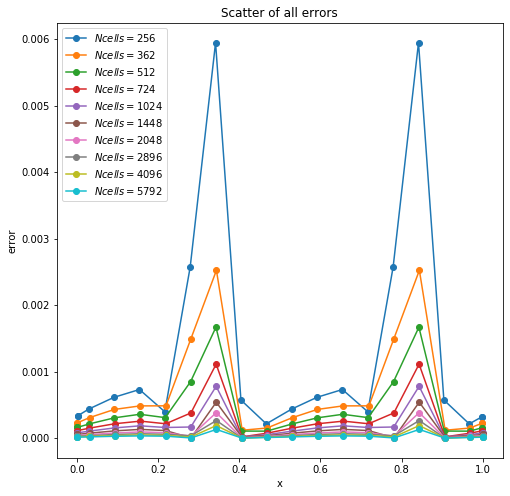

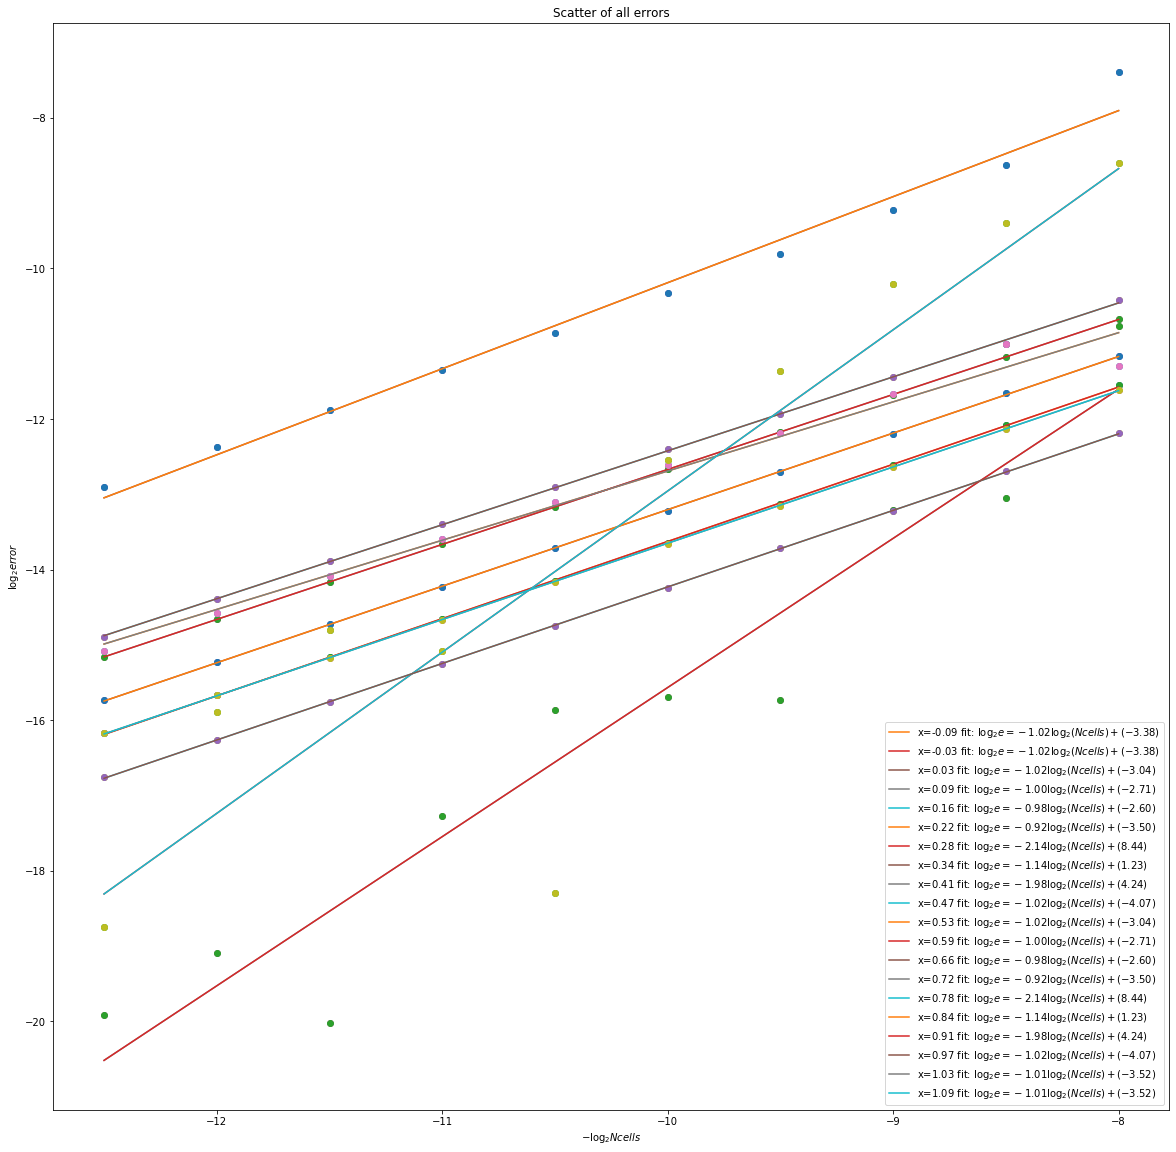

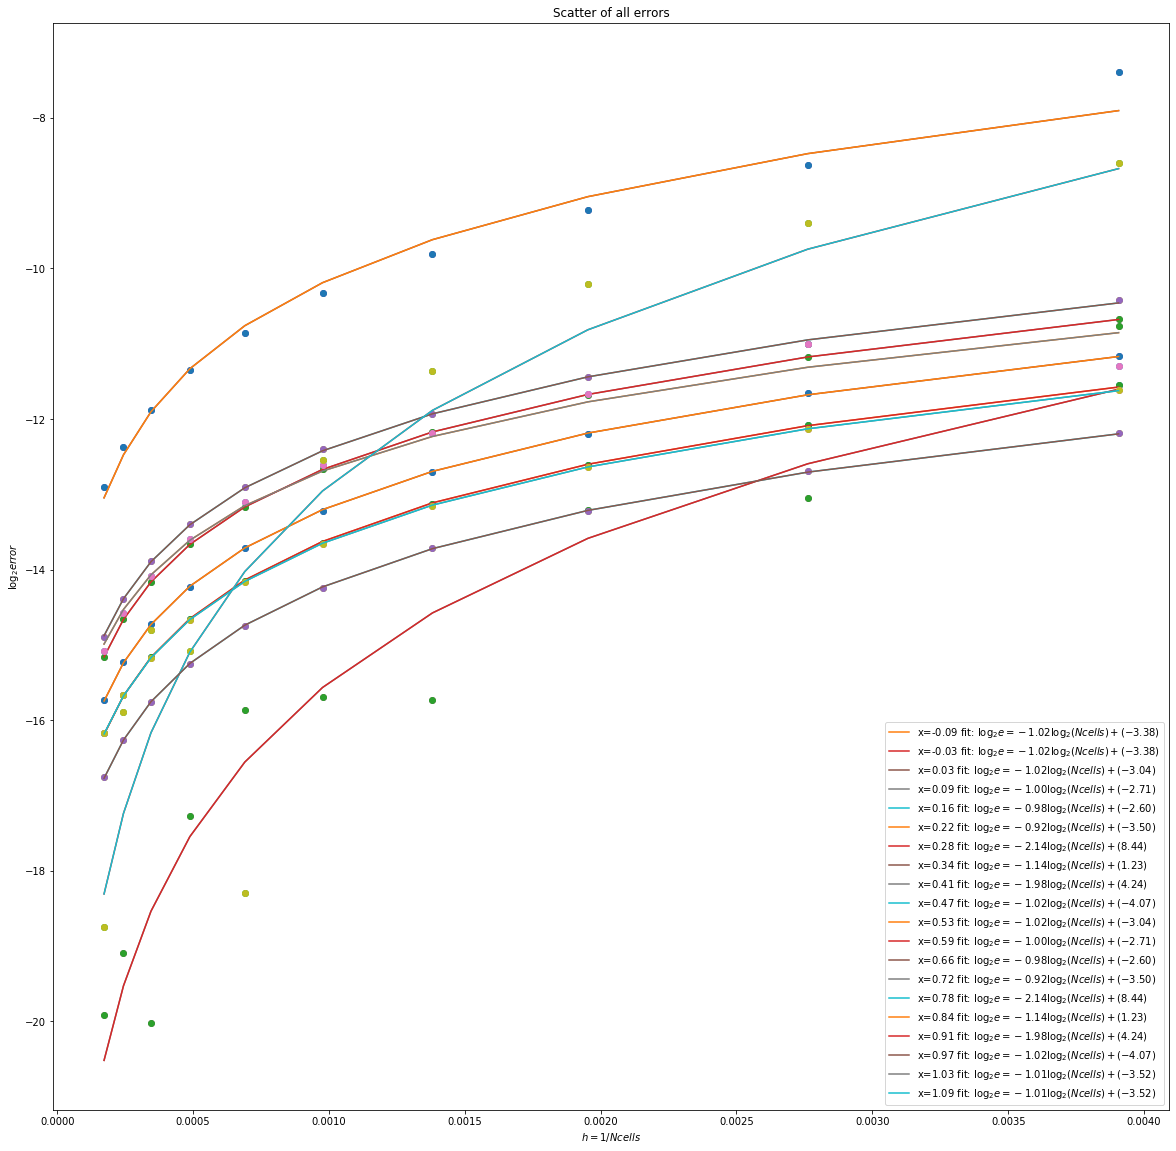

In [6]:

plt.rcParams["figure.figsize"] = (8,8)
for i in range(len(comp_x_list_list)):
    plt.plot(comp_x_list_list[i], comp_error_list_list[i], "-o", label=r"$Ncells={%d}$" % Ncell_list[i])
    plt.xlabel("x")
    plt.ylabel("error")
    plt.title("Scatter of all errors")
    plt.legend()
plt.savefig("allerrors.png")
plt.show()

# log-log
plt.rcParams["figure.figsize"] = (20,20)
for i in range(len(ref_x_list)):
    error_list = [np.log2(comp_error_list[i]) for comp_error_list in comp_error_list_list]
    minus_n_list = [-n for n in n_list]
    p = np.polyfit(minus_n_list, error_list, 1)
    plt.plot(minus_n_list, error_list, 'o')
    plt.plot(minus_n_list, [p[0] * n + p[1] for n in minus_n_list], label=r"x=%.2f fit: $\log_2 e = - %.2f \log_2(Ncells) + (%.2f)$" % (ref_x_list[i],p[0], p[1]))
    plt.xlabel(r'$-\log_2 Ncells$')
    plt.ylabel(r'$\log_2 error$')
    plt.title("Scatter of all errors")
    plt.legend()
plt.savefig("pointwise.png")
plt.show()

# semilog-log
plt.rcParams["figure.figsize"] = (20,20)
for i in range(len(ref_x_list)):
    error_list = [np.log2(comp_error_list[i]) for comp_error_list in comp_error_list_list]
    minus_n_list = [-n for n in n_list]
    h_list = [2**minus_n for minus_n in minus_n_list]
    p = np.polyfit(minus_n_list, error_list, 1)
    plt.plot(h_list, error_list, 'o')
    plt.plot(h_list, [p[0] * n + p[1] for n in minus_n_list], label=r"x=%.2f fit: $\log_2 e = - %.2f \log_2(Ncells) + (%.2f)$" % (ref_x_list[i],p[0], p[1]))
    plt.xlabel(r'$h=1/Ncells$')
    plt.ylabel(r'$\log_2 error$')
    plt.title("Scatter of all errors")
    plt.legend()
plt.savefig("pointwise.png")
plt.show()

## Discussion
As we can see, not everywhere in x-axis the method can reach second order convergence.

# Pointwise Comparison (Linear)

## Data generation

In [7]:
n_list = np.arange(8, 13, 0.5)
Ncell_list = [int(2**n) for n in n_list]

# time selection
t=0.25

# containers for the errors
comp_error_list_list = []
comp_x_list_list = []
ref_x_list = None

# set the reference x list for comparison
ref_burgers = Burgers(16, 'sine')
ref_x_list = ref_burgers._x

for Ncells in Ncell_list:
    burgers = Burgers(Ncells, 'sine', interpolation="linear")
    burgers.evolve(save=False)
    plt.clf()
    index = int(len(burgers._tList) * t)

    x_list = burgers._x[burgers.Nghost:-burgers.Nghost]
    u_list = burgers._uxList[index][burgers.Nghost:-burgers.Nghost]
    true_u_list = [burgers.exact_soln(t, x) for x in x_list]
    error = abs(u_list - true_u_list)

    comp_x_list = [min(x_list, key=lambda x : abs(x-ref_x)) for ref_x in ref_x_list]
    comp_x_list_list.append(comp_x_list)
    comp_index_list = [np.argmin(abs(x_list-comp_x)) for comp_x in comp_x_list]
    comp_u_list = [u_list[index] for index in comp_index_list]
    comp_true_u_list = [burgers.exact_soln(t, x) for x in comp_x_list]
    comp_error_list_list.append(abs(np.array(comp_true_u_list)-np.array(comp_u_list)))



<Figure size 1440x1440 with 0 Axes>

## Plotting

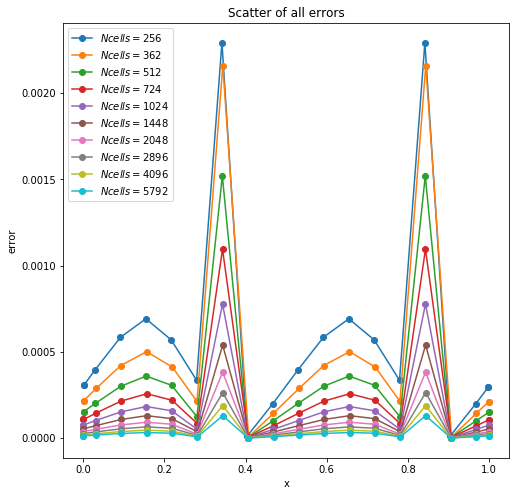

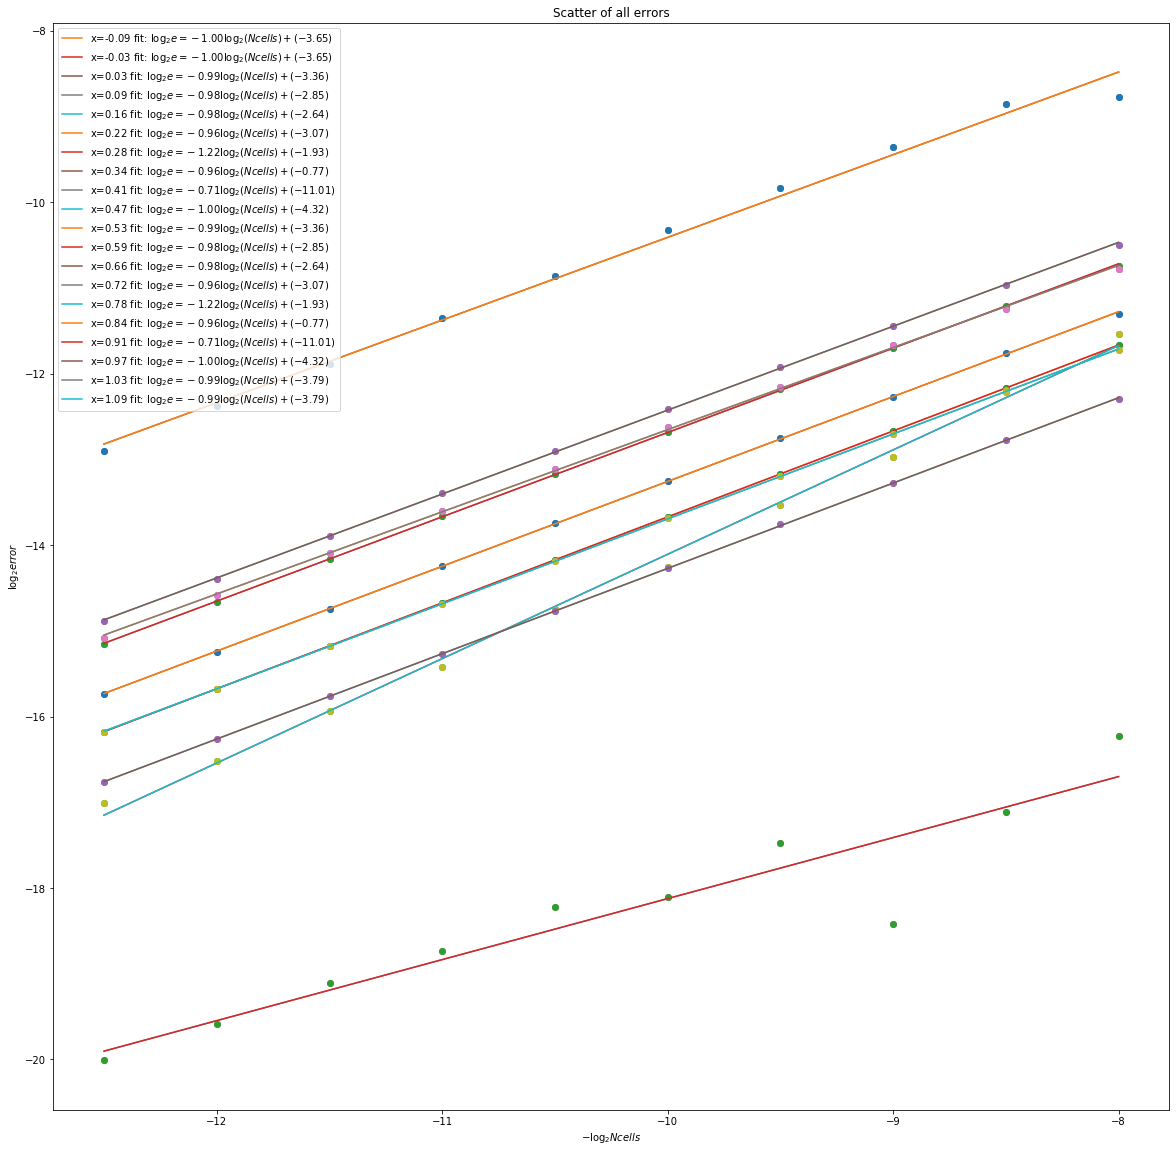

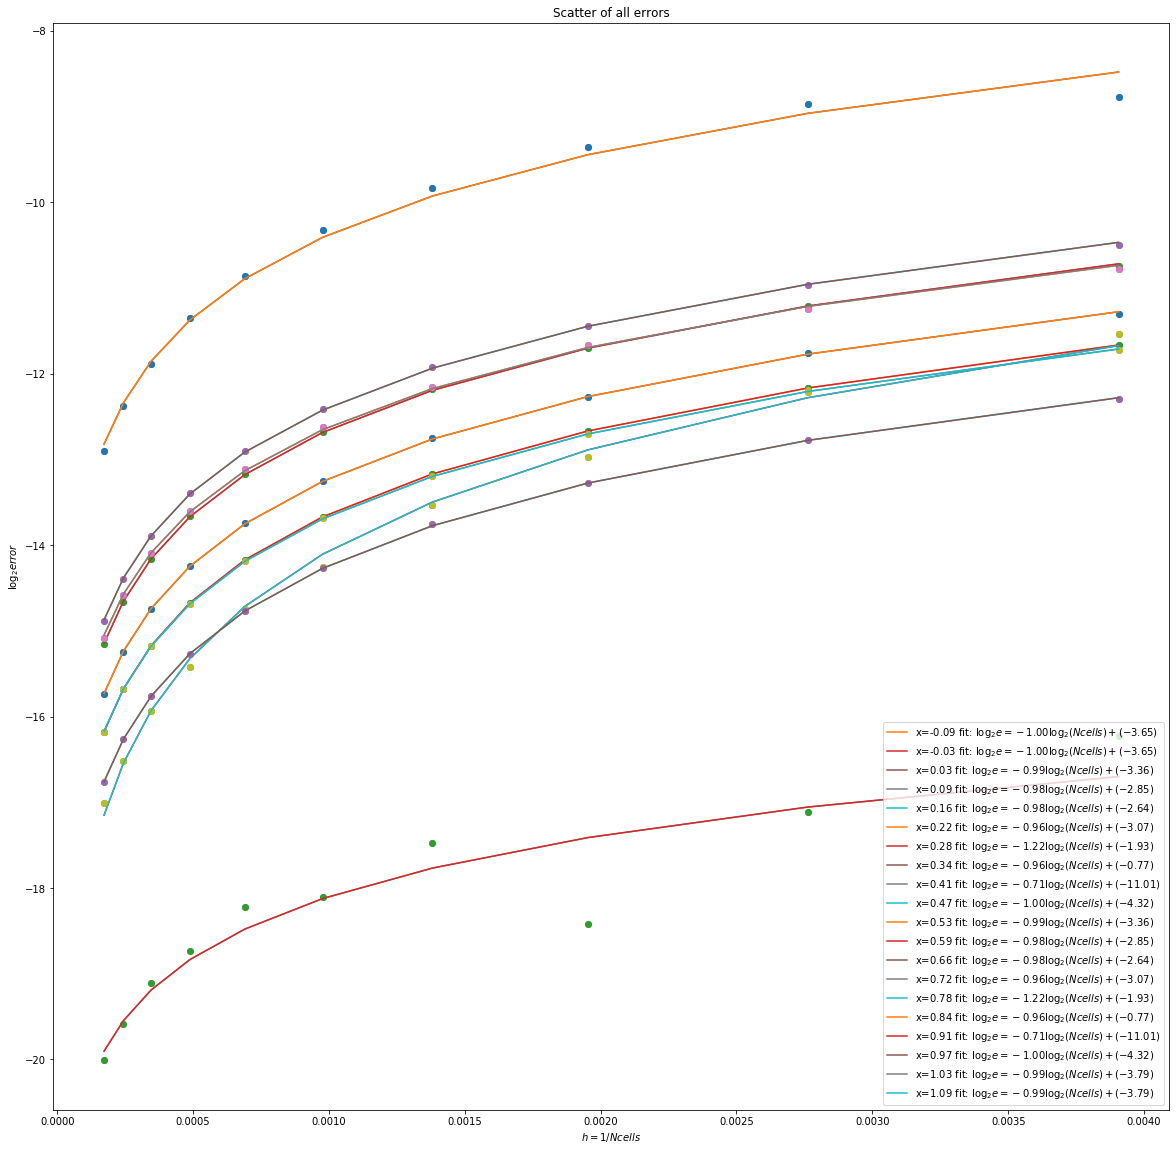

In [9]:

plt.rcParams["figure.figsize"] = (8,8)
for i in range(len(comp_x_list_list)):
    plt.plot(comp_x_list_list[i], comp_error_list_list[i], "-o", label=r"$Ncells={%d}$" % Ncell_list[i])
    plt.xlabel("x")
    plt.ylabel("error")
    plt.title("Scatter of all errors")
    plt.legend()
plt.savefig("linear_allerrors.png")
plt.show()

# log-log
plt.rcParams["figure.figsize"] = (20,20)
for i in range(len(ref_x_list)):
    error_list = [np.log2(comp_error_list[i]) for comp_error_list in comp_error_list_list]
    minus_n_list = [-n for n in n_list]
    p = np.polyfit(minus_n_list, error_list, 1)
    plt.plot(minus_n_list, error_list, 'o')
    plt.plot(minus_n_list, [p[0] * n + p[1] for n in minus_n_list], label=r"x=%.2f fit: $\log_2 e = - %.2f \log_2(Ncells) + (%.2f)$" % (ref_x_list[i],p[0], p[1]))
    plt.xlabel(r'$-\log_2 Ncells$')
    plt.ylabel(r'$\log_2 error$')
    plt.title("Scatter of all errors")
    plt.legend()
plt.savefig("linear_pointwise_loglog.png")
plt.show()

# semilog-log
plt.rcParams["figure.figsize"] = (20,20)
for i in range(len(ref_x_list)):
    error_list = [np.log2(comp_error_list[i]) for comp_error_list in comp_error_list_list]
    minus_n_list = [-n for n in n_list]
    h_list = [2**minus_n for minus_n in minus_n_list]
    p = np.polyfit(minus_n_list, error_list, 1)
    plt.plot(h_list, error_list, 'o')
    plt.plot(h_list, [p[0] * n + p[1] for n in minus_n_list], label=r"x=%.2f fit: $\log_2 e = - %.2f \log_2(Ncells) + (%.2f)$" % (ref_x_list[i],p[0], p[1]))
    plt.xlabel(r'$h=1/Ncells$')
    plt.ylabel(r'$\log_2 error$')
    plt.title("Scatter of all errors")
    plt.legend()
plt.savefig("linear_pointwise.png")
plt.show()

## Discussion
Apparently, the linear method works quite worse than minmod.